In [1]:
import cv2
import os
import sys
import numpy as np
import pickle
import importlib
from math import floor
from PIPNet.FaceBoxesV2.faceboxes_detector import *
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
# from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models
import seaborn as sns
import pandas as pd
import dask.dataframe as dd
from PIPNet.lib.networks import *
import PIPNet.lib.data_utils
from PIPNet.lib.functions import *
from PIPNet.lib.mobilenetv3 import mobilenetv3_large
from L2CS_Net.model import L2CS
from L2CS_Net.utils import draw_gaze
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from read_json import read_left_eye_opened, read_right_eye_opened
from scipy.spatial import distance
from torch.utils import data
import matplotlib.pyplot as plt
import joblib

In [11]:
input_size = 256
net_stride = 32
num_nb = 10
data_name = 'data_300W'
experiment_name = 'pip_32_16_60_r101_l2_l1_10_1_nb10'
num_lms = 68

transformations = transforms.Compose([transforms.Resize(448), transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

print(torch.backends.cudnn.enabled)
# torch.backends.cuda.matmul.allow_tf32 = True

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface(os.path.join('PIPNet/data', data_name, 'meanface.txt'), num_nb)

resnet101 = models.resnet101(pretrained=True)
landmark_net = Pip_resnet101(resnet101, num_nb=num_nb, num_lms=num_lms, input_size=input_size, net_stride=net_stride)

device = torch.device("cuda")

landmark_net = landmark_net.to(device)
save_dir = os.path.join('PIPNet/snapshots', data_name, experiment_name)
weight_file = os.path.join(save_dir, 'epoch%d.pth' % (60 - 1))
state_dict = torch.load(weight_file, map_location=device)
landmark_net.load_state_dict(state_dict)
landmark_net.eval()

gaze_net = L2CS(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 90)
gaze_net = gaze_net.to(device)
saved_state_dict = torch.load("./L2CS_Net/snapshot/L2CSNet_gaze360.pkl", map_location=device)
gaze_net.load_state_dict(saved_state_dict)
gaze_net.eval()
softmax = nn.Softmax(dim=1).to(device)
idx_tensor = [idx for idx in range(90)]
idx_tensor = torch.FloatTensor(idx_tensor).to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor(), normalize])

face_detector = FaceBoxesDetector('FaceBoxes', 'PIPNet/FaceBoxesV2/weights/FaceBoxesV2.pth', True, device)

my_thresh = 0.6
det_box_scale = 1.2

#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#writer = cv2.VideoWriter('.' + os.sep + 'real_drive.mp4', fourcc, fps, (image_width, image_height))

True


/home/jinbeom/workspace/driver_monitor/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jinbeom/workspace/driver_monitor/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
image_dir_path = './dataset/training/image_realdrive/1.버스'
image_dir_names = os.listdir(image_dir_path)
image_dir_names.sort()
image_path_list = []

for image_dir_name in image_dir_names:
    image_names = os.listdir(os.path.join(image_dir_path, image_dir_name))
    image_names.sort()

    for image_name in image_names:
        image_path_list.append(os.path.join(image_dir_path, image_dir_name, image_name))

label_dir_path = './dataset/training/label_realdrive/1.버스'
label_dir_names = os.listdir(label_dir_path)
label_dir_names.sort()
label_path_list = []

for label_dir_name in label_dir_names:
    label_names = os.listdir(os.path.join(label_dir_path, label_dir_name))
    label_names.sort()

    for label_name in label_names:
        label_path_list.append(os.path.join(label_dir_path, label_dir_name, label_name))

image = cv2.imread(image_path_list[0])
# ret, frame = video.read()
image_height, image_width, dim = image.shape

fps = 5

In [23]:
class ImgDataset(data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = cv2.imread(img_path)

        return img

In [24]:
infer_dataset =  ImgDataset(file_list=image_path_list)
infer_data_loader = data.DataLoader(infer_dataset, batch_size=1000, num_workers=0)
print(type(infer_data_loader))

#detections, _ = face_detector.detect(infer_data_loader, my_thresh, 1)


<class 'torch.utils.data.dataloader.DataLoader'>


In [9]:
model = joblib.load('./model.pkl')

In [15]:
actual_result = []
pred_result = []
actual_result_set = []
pred_result_set = []

for label_path in tqdm(label_path_list, ncols=100, desc='inference processing...'):
    start_fps = time.time()
    frame = cv2.imread(os.path.join(image_dir_path, label_path.split('/')[5], label_path.split('/')[6].rstrip('json')+'jpg'))
    detections, _ = face_detector.detect(frame, my_thresh, 1)
    driver_status = read_left_eye_opened(label_path) and read_right_eye_opened(label_path)

    for i in range(len(detections)):
        det_xmin = detections[i][2]
        det_ymin = detections[i][3]
        det_width = detections[i][4]
        det_height = detections[i][5]
        det_xmax = det_xmin + det_width - 1
        det_ymax = det_ymin + det_height - 1

        det_xmin -= int(det_width * (det_box_scale - 1) / 2)
        # remove a part of top area for alignment, see paper for details
        det_ymin += int(det_height * (det_box_scale - 1) / 2)
        det_xmax += int(det_width * (det_box_scale - 1) / 2)
        det_ymax += int(det_height * (det_box_scale - 1) / 2)
        det_xmin = max(det_xmin, 0)
        det_ymin = max(det_ymin, 0)
        det_xmax = min(det_xmax, image_width - 1)
        det_ymax = min(det_ymax, image_height - 1)
        det_width = det_xmax - det_xmin + 1
        det_height = det_ymax - det_ymin + 1
        # cv2.rectangle(frame, (det_xmin, det_ymin), (det_xmax, det_ymax), (255, 255, 255), 2)
        det_crop = frame[det_ymin:det_ymax, det_xmin:det_xmax, :]
        det_crop = cv2.resize(det_crop, (input_size, input_size))
        inputs = Image.fromarray(det_crop[:, :, ::-1].astype('uint8'), 'RGB')
        inputs = preprocess(inputs).unsqueeze(0)
        inputs = inputs.to(device)
        lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(landmark_net, inputs,
                                                                                                 preprocess, input_size,
                                                                                                 net_stride, num_nb)
        lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
        tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(num_lms, max_len)
        tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(num_lms, max_len)
        tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1, 1)
        tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1, 1)
        lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()
        lms_pred = lms_pred.cpu().numpy()
        lms_pred_merge = lms_pred_merge.cpu().numpy()

        eye_x = (lms_pred_merge[36 * 2:48 * 2:2] * det_width).astype(np.int32) + det_xmin
        eye_y = (lms_pred_merge[(36 * 2) + 1:(48 * 2) + 1:2] * det_height).astype(np.int32) + det_ymin

        left_eye_H_dist = distance.euclidean((eye_x[0], eye_y[0]), (eye_x[3], eye_y[3]))
        left_eye_V_dist = distance.euclidean((eye_x[1], eye_y[1]), (eye_x[5], eye_y[5]))\
                          + distance.euclidean((eye_x[2], eye_y[2]), (eye_x[4], eye_y[4]))

        right_eye_H_dist = distance.euclidean((eye_x[6], eye_y[6]), (eye_x[9], eye_y[9]))
        right_eye_V_dist = distance.euclidean((eye_x[11], eye_y[11]), (eye_x[7], eye_y[7]))\
                           + distance.euclidean((eye_x[10], eye_y[10]), (eye_x[8], eye_y[8]))

        left_eye_ratio = left_eye_V_dist/left_eye_H_dist
        right_eye_ratio = right_eye_V_dist/right_eye_H_dist


        result = model.predict(np.array([left_eye_H_dist, left_eye_V_dist, right_eye_H_dist, right_eye_V_dist]).reshape(1, -1) ,num_iteration=model.best_iteration_)
        result_color = (255, 255, 255) if result == 1 else (0, 0, 255)
        cv2.rectangle(frame, (det_xmin, det_ymin), (det_xmax, det_ymax), result_color, 2)

        #left_eye_ratio = (np.max(eye_y[4:6]) - np.min(eye_y[1:3])) / (eye_x[3] - eye_x[0])
        #right_eye_ratio = (np.max(eye_y[10:12]) - np.min(eye_y[7:9])) / (eye_x[9] - eye_x[6])
        eye_det = 0.25

        left_eye_color = (0, 255, 0) if left_eye_ratio > eye_det else (0, 0, 255)
        right_eye_color = (0, 255, 0) if right_eye_ratio > eye_det else (0, 0, 255)

        for i in range(len(eye_x)):
            if i <= 5:
                cv2.circle(frame, (eye_x[i], eye_y[i]), 1, left_eye_color, 2)
            else:
                cv2.circle(frame, (eye_x[i], eye_y[i]), 1, right_eye_color, 2)

        if left_eye_ratio > eye_det and right_eye_ratio > eye_det:
            img = frame[det_ymin:det_ymax, det_xmin:det_xmax]
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im_pil = Image.fromarray(img)
            img = transformations(im_pil)
            img = Variable(img).to(device)
            img = img.unsqueeze(0)

            # gaze prediction
            #gaze_pitch, gaze_yaw = gaze_net(img)
            #pitch_predicted = softmax(gaze_pitch)
            #yaw_predicted = softmax(gaze_yaw)

            #pitch_predicted = torch.sum(pitch_predicted.data[0] * idx_tensor) * 4 - 180
            #yaw_predicted = torch.sum(yaw_predicted.data[0] * idx_tensor) * 4 - 180

            #pitch_predicted = pitch_predicted.cpu().detach().numpy() * np.pi / 180.0
            #yaw_predicted = yaw_predicted.cpu().detach().numpy() * np.pi / 180.0

            #draw_gaze(det_xmin, det_ymin, det_width, det_height, frame, (pitch_predicted, yaw_predicted), color=(0, 0, 255))

        cv2.putText(frame, f'{left_eye_ratio:.2f}', (det_xmin, det_ymax+30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        cv2.putText(frame, f'{right_eye_ratio:.2f}', (det_xmax-50, det_ymax + 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

    fps_act = 1.0 / (time.time() - start_fps)
    cv2.putText(frame, f'FPS: {fps_act:.1f}', (10, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(frame, f'Driver Stats: {driver_status}', (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1, cv2.LINE_AA)

    actual_result_set.append([left_eye_H_dist, left_eye_V_dist, right_eye_H_dist, right_eye_V_dist, driver_status])

    cv2.imshow('frame', frame)

    if cv2.waitKey(200) & 0xFF == ord('q'): break
    if driver_status:
        actual_result.append(1)
    else:
        actual_result.append(0)

    if left_eye_ratio > eye_det and right_eye_ratio > eye_det:
        pred_result.append(1)
    else: pred_result.append(0)

cv2.destroyAllWindows()

np.save('./actual', np.array(actual_result_set))

print('Image Inference Done')

inference processing...:   0%|                                            | 0/65132 [00:00<?, ?it/s]/home/jinbeom/workspace/driver_monitor/PIPNet/lib/functions.py:191: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
/home/jinbeom/workspace/driver_monitor/PIPNet/lib/functions.py:196: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for a

Image Inference Done


In [6]:
data = pd.DataFrame(actual_result_set, columns=['left_eye_H_dist', 'left_eye_V_dist', 'right_eye_H_dist', 'right_eye_V_dist', 'driver_status'])
data.to_csv('./actual_result.csv', index=False)
data_2 = dd.from_pandas(data, npartitions=10)

CPU times: user 27.1 s, sys: 5.87 s, total: 33 s
Wall time: 25.9 s


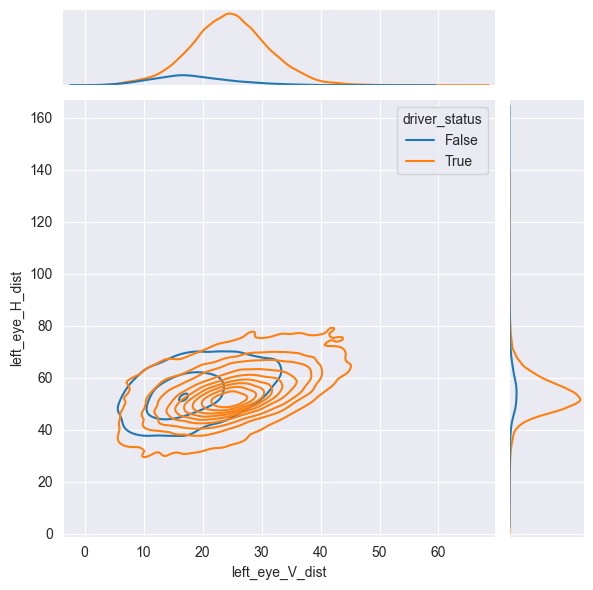

In [8]:
%time sns.jointplot(x='left_eye_V_dist', y='left_eye_H_dist', data=data, hue='driver_status', kind='kde')
plt.show()

In [54]:
data['left_eye_ratio'] = data['left_eye_V_dist']/data['left_eye_H_dist']
data['right_eye_ratio'] = data['right_eye_V_dist']/data['right_eye_H_dist']
data

,left_eye_H_dist,left_eye_V_dist,right_eye_H_dist,right_eye_V_dist,driver_status,left_eye_ratio,right_eye_ratio
0,48.507731,21.378379,54.083269,21.210636,True,0.440721,0.392185
1,47.675990,18.274930,55.027266,21.210636,True,0.383315,0.385457
2,47.675990,20.396078,54.405882,24.074017,True,0.427806,0.442489
3,49.819675,21.378379,54.817880,26.250581,True,0.429115,0.478869
4,49.030603,22.360680,54.120237,26.683328,True,0.456056,0.493038
...,...,...,...,...,...,...,...
65127,62.513998,34.029386,62.201286,34.000000,True,0.544348,0.546612
65128,62.513998,34.029386,62.201286,34.000000,True,0.544348,0.546612
65129,61.522354,33.031220,59.008474,32.031220,True,0.536898,0.542824
65130,60.207973,27.470768,54.083269,29.035669,True,0.456265,0.536870


KeyboardInterrupt: 

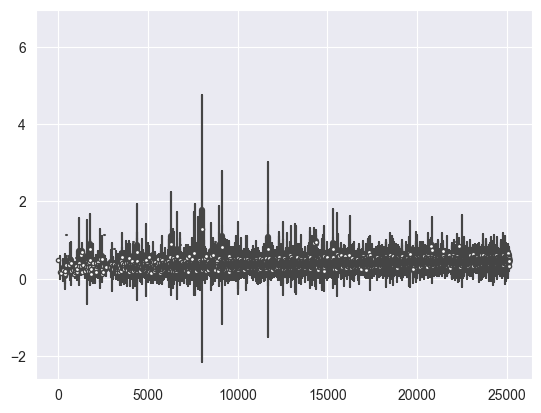

In [ ]:
sns.violinplot(x='left_eye_ratio', y=data['right_eye_V_dist']/data['right_eye_H_dist'])
plt.show()

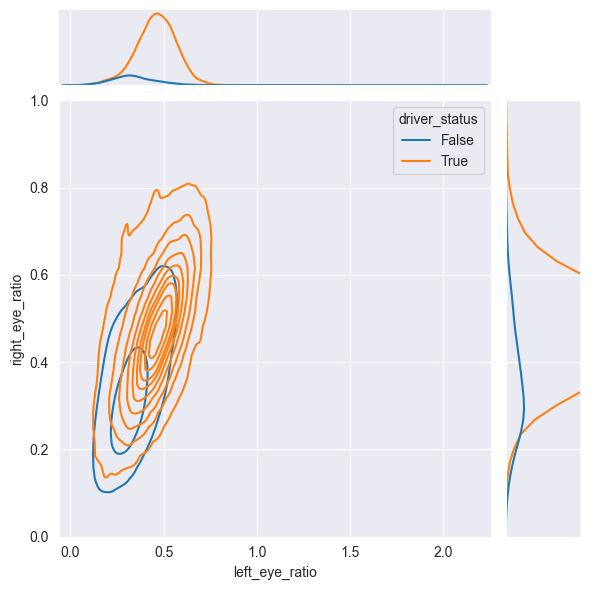

In [56]:
sns.jointplot(x='left_eye_ratio', y='right_eye_ratio', data=data, hue='driver_status', kind='kde')
plt.xlim([0, 1.5])
plt.ylim([0, 1])
plt.show()

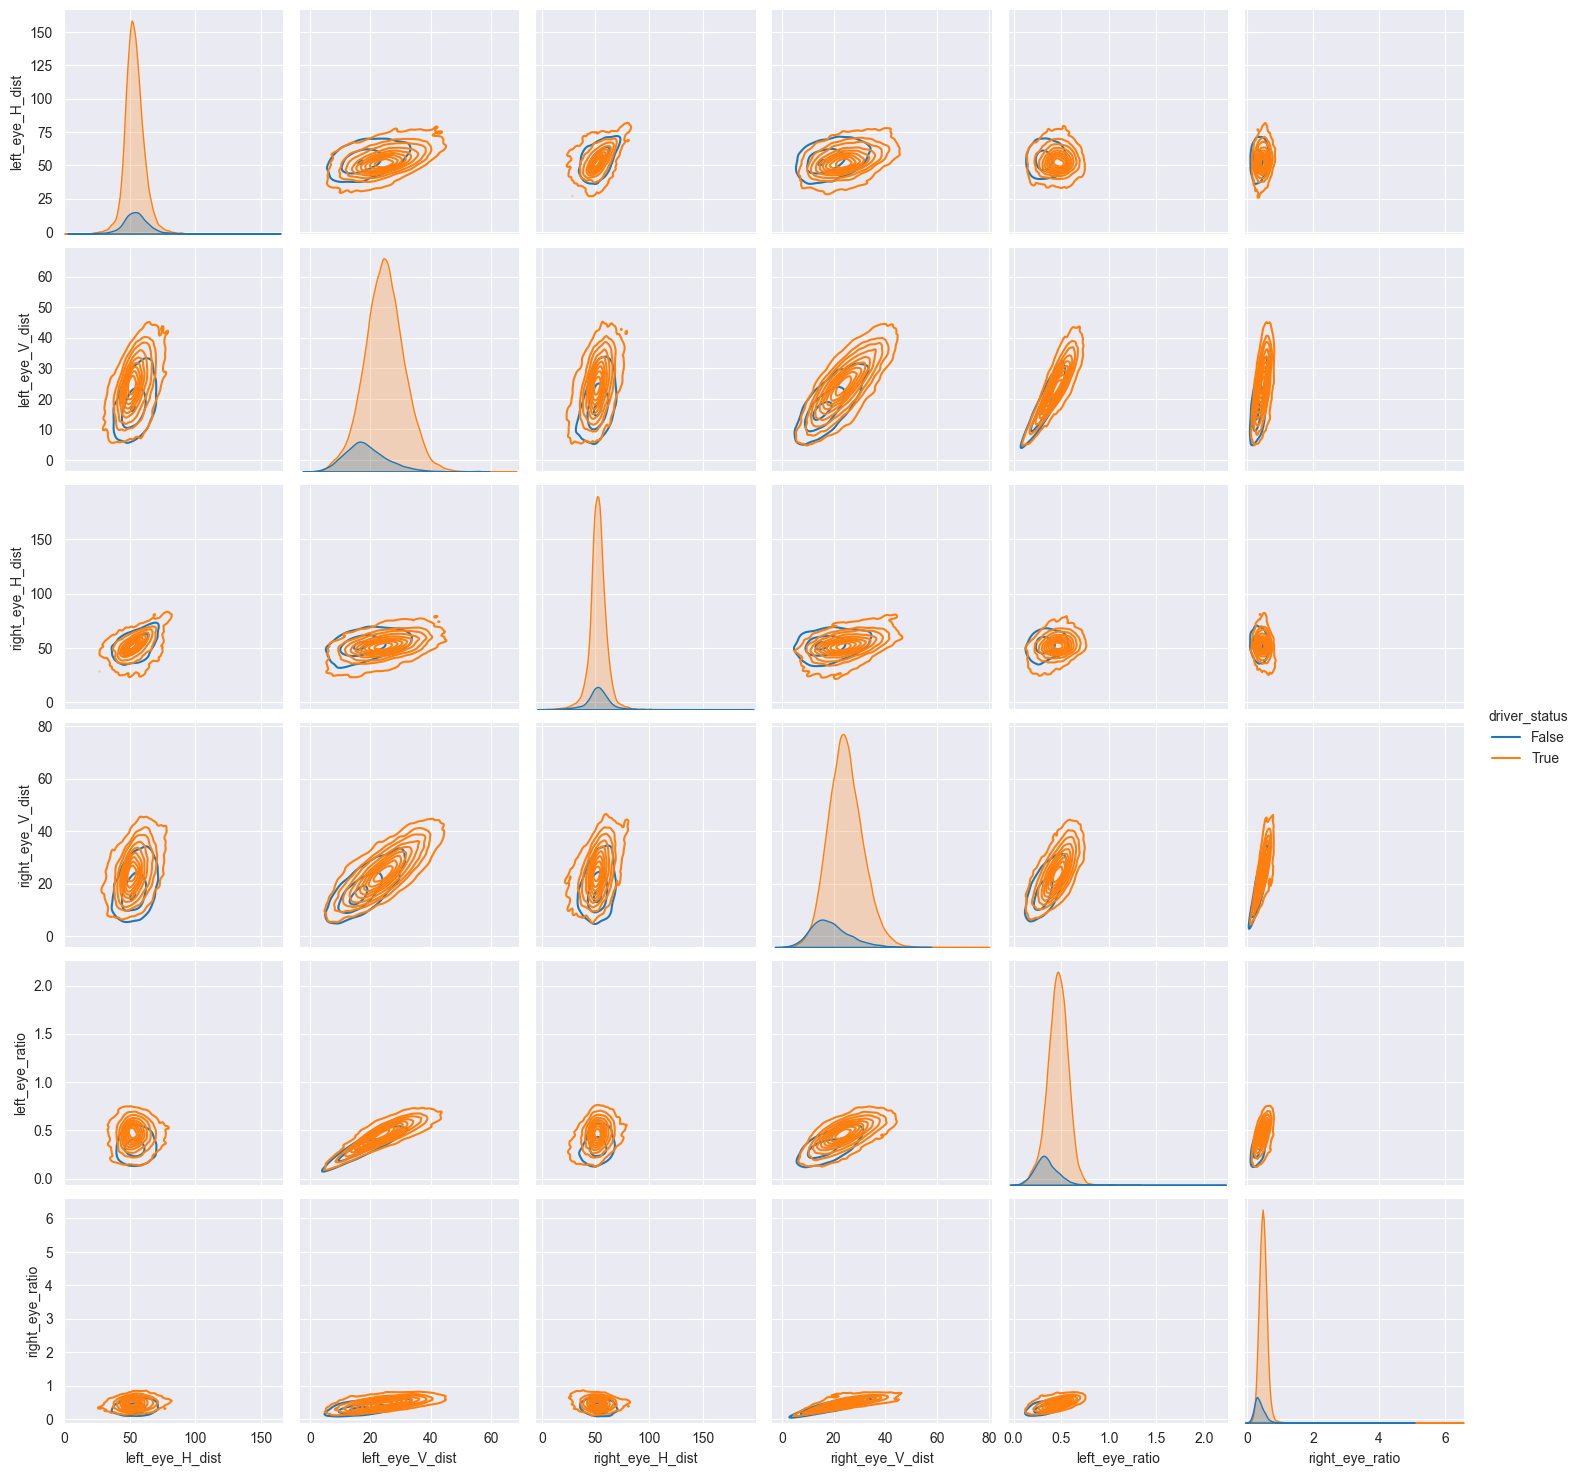

In [42]:
sns.pairplot(data, hue="driver_status", kind='kde')
plt.show()

In [30]:
confusion_matrix(actual_result, pred_result)

array([[ 2702,  5358],
       [ 2785, 54287]])

In [31]:
print(classification_report(actual_result, pred_result))

              precision    recall  f1-score   support

           0       0.49      0.34      0.40      8060
           1       0.91      0.95      0.93     57072

    accuracy                           0.87     65132
   macro avg       0.70      0.64      0.66     65132
weighted avg       0.86      0.87      0.86     65132

